In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer

# Veri yükle
df = pd.read_csv("Skin.csv")
df = df.dropna(subset=["aciklama", "cilt_problemi", "cilttipi", "onerilen_urun"])

# Label encode
le_problemi = LabelEncoder()
df["problemi_encoded"] = le_problemi.fit_transform(df["cilt_problemi"])

# Train-test böl
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer
model_name = "dbmdz/bert-base-turkish-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["aciklama"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

train_dataset = train_dataset.rename_column("problemi_encoded", "labels")
test_dataset = test_dataset.rename_column("problemi_encoded", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/602 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

model_prob = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(le_problemi.classes_)
)

model_prob.to(device) 

training_args = TrainingArguments(
    output_dir="./bert-problem-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    logging_dir="./logs-problem",
    logging_strategy="steps",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer_prob = Trainer(
    model=model_prob,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_prob.train()

model_prob.save_pretrained("./bert-problem-model")
tokenizer.save_pretrained("./bert-problem-model")


Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/fj/49__nmss1vq863jvp8hjmy7r0000gn/T/ipykernel_42169/3713418039.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_prob = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,2.138100,1.428504,0.701987
2,0.821700,0.573008,0.854305
3,0.392500,0.299959,0.940397
4,0.217500,0.285475,0.920530
5,0.061600,0.340889,0.913907


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


('./bert-problem-model/tokenizer_config.json',
 './bert-problem-model/special_tokens_map.json',
 './bert-problem-model/vocab.txt',
 './bert-problem-model/added_tokens.json',
 './bert-problem-model/tokenizer.json')

In [3]:
def predict_problemi(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model_prob(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
        confidence = torch.softmax(outputs.logits, dim=1)[0][pred_id].item()
    label = le_problemi.inverse_transform([pred_id])[0]
    print(f"💬 Açıklama: {text}")
    print(f"🔍 Tahmin Edilen Cilt Problemi: {label} (%{confidence*100:.2f})")
    return label, confidence


In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_prob.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


                     precision    recall  f1-score   support

  alerjik reaksiyon       1.00      1.00      1.00         3
          batık kıl       1.00      1.00      1.00         2
           dermatit       0.80      0.67      0.73         6
            döküntü       1.00      1.00      1.00         3
             egzama       1.00      0.67      0.80         3
  elastikiyet kaybı       1.00      1.00      1.00         8
      geniş gözenek       1.00      1.00      1.00        10
gözenek tıkanıklığı       1.00      0.75      0.86         8
       güneş lekesi       0.80      1.00      0.89         4
  hiperpigmentasyon       1.00      1.00      1.00         7
   hipopigmentasyon       1.00      1.00      1.00         7
         kabuklanma       0.67      1.00      0.80         6
         kırışıklık       1.00      1.00      1.00        10
         kızarıklık       1.00      0.86      0.92         7
               leke       0.83      0.83      0.83         6
             milium    

/var/folders/fj/49__nmss1vq863jvp8hjmy7r0000gn/T/ipykernel_42169/3317848140.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


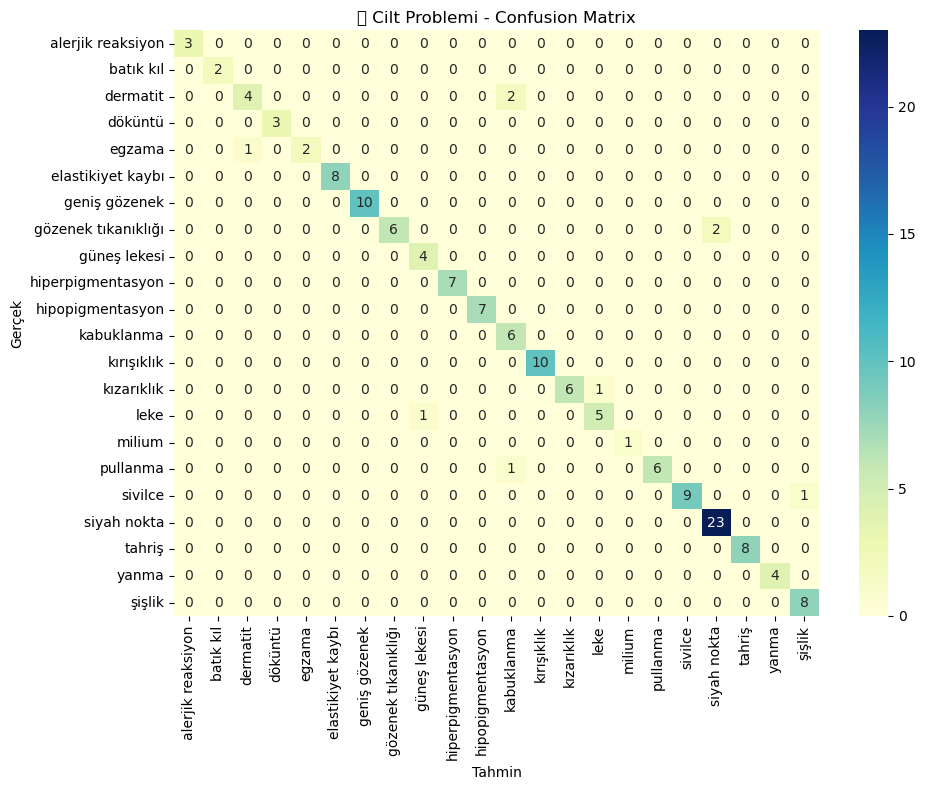

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Gerçek vs tahmin
true_labels = test_dataset["labels"]
pred_labels = []

model_prob.eval()
for i in range(len(test_dataset)):
    input_ids = test_dataset[i]["input_ids"].unsqueeze(0).to(device)
    attention_mask = test_dataset[i]["attention_mask"].unsqueeze(0).to(device)
    with torch.no_grad():
        output = model_prob(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(output.logits, dim=1).item()
    pred_labels.append(pred)

# Rapor ve Matrix
print(classification_report(true_labels, pred_labels, target_names=le_problemi.classes_))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le_problemi.classes_, yticklabels=le_problemi.classes_, cmap="YlGnBu")
plt.title("🔍 Cilt Problemi - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.show()


In [6]:
predict_problemi("Yüzümde sürekli iltihaplı sivilceler çıkıyor, özellikle alın ve çenede.")

💬 Açıklama: Yüzümde sürekli iltihaplı sivilceler çıkıyor, özellikle alın ve çenede.
🔍 Tahmin Edilen Cilt Problemi: sivilce (%63.98)


('sivilce', 0.6397726535797119)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer

# Veri yükle
df = pd.read_csv("Skin.csv")
df = df.dropna(subset=["aciklama", "cilttipi", "cilt_problemi", "onerilen_urun"])

# Label encode
le_cilt = LabelEncoder()
df["cilttipi_encoded"] = le_cilt.fit_transform(df["cilttipi"])

# Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer
model_name = "dbmdz/bert-base-turkish-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["aciklama"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

train_dataset = train_dataset.rename_column("cilttipi_encoded", "labels")
test_dataset = test_dataset.rename_column("cilttipi_encoded", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/602 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

In [8]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import torch

# Accuracy metriği
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

# Model
model_cilt = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(le_cilt.classes_)
)

# Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./bert-cilt-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    logging_dir="./logs-cilt",
    logging_strategy="steps",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# Trainer
trainer_cilt = Trainer(
    model=model_cilt,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_cilt.train()

# Kaydet
model_cilt.save_pretrained("./bert-cilt-model")
tokenizer.save_pretrained("./bert-cilt-model")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/fj/49__nmss1vq863jvp8hjmy7r0000gn/T/ipykernel_42169/3759556469.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cilt = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.240100,0.062015,0.986755
2,0.006600,0.002702,1.000000
3,0.001900,0.001175,1.000000
4,0.001200,0.000838,1.000000


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


('./bert-cilt-model/tokenizer_config.json',
 './bert-cilt-model/special_tokens_map.json',
 './bert-cilt-model/vocab.txt',
 './bert-cilt-model/added_tokens.json',
 './bert-cilt-model/tokenizer.json')

In [ ]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model_cilt.to(device)
print(f"Using device: {device}")



Using device: mps


In [10]:
def predict_all(prompt, df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Cilt tipi tahmini ---
    inputs_cilt = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs_cilt = {k: v.to(device) for k, v in inputs_cilt.items()}
    model_cilt.to(device)
    with torch.no_grad():
        outputs_cilt = model_cilt(**inputs_cilt)
        pred_id_cilt = torch.argmax(outputs_cilt.logits, dim=1).item()
        confidence_cilt = torch.softmax(outputs_cilt.logits, dim=1)[0][pred_id_cilt].item()
    cilttipi = le_cilt.inverse_transform([pred_id_cilt])[0]

    # --- Cilt problemi tahmini ---
    inputs_prob = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs_prob = {k: v.to(device) for k, v in inputs_prob.items()}
    model_prob.to(device)
    with torch.no_grad():
        outputs_prob = model_prob(**inputs_prob)
        pred_id_prob = torch.argmax(outputs_prob.logits, dim=1).item()
        confidence_prob = torch.softmax(outputs_prob.logits, dim=1)[0][pred_id_prob].item()
    problemi = le_problemi.inverse_transform([pred_id_prob])[0]

    # --- Öneri çek ---
    öneri = df[(df["cilttipi"] == cilttipi) & (df["cilt_problemi"] == problemi)]
    urun = öneri["onerilen_urun"].values[0] if not öneri.empty else "Veri bulunamadı"

    # --- Çıktı ---
    print("🧠 Tahminler:")
    print(f"💧 Cilt Tipi      : {cilttipi} (%{confidence_cilt*100:.2f})")
    print(f"🔍 Cilt Problemi  : {problemi} (%{confidence_prob*100:.2f})")
    print("🎁 Önerilen Ürün:")
    print(f"   💊 {urun}")


In [11]:
predict_all("Cildim pul pul dökülüyor ve yüzümde kırmızı kabarcıklar var.", df)


🧠 Tahminler:
💧 Cilt Tipi      : kuru (%95.83)
🔍 Cilt Problemi  : pullanma (%78.92)
🎁 Önerilen Ürün:
   💊 hyaluronik asit serum, yoğun nemlendirici krem, bariyer onarıcı krem, gliserin içerikli losyon, nem maskesi


🧠 Cilt Tipi - Classification Report:

              precision    recall  f1-score   support

      hassas       1.00      1.00      1.00        35
        kuru       1.00      1.00      1.00        12
      normal       1.00      1.00      1.00        44
       yağlı       1.00      1.00      1.00        60

    accuracy                           1.00       151
   macro avg       1.00      1.00      1.00       151
weighted avg       1.00      1.00      1.00       151



/var/folders/fj/49__nmss1vq863jvp8hjmy7r0000gn/T/ipykernel_42169/3769318507.py:40: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


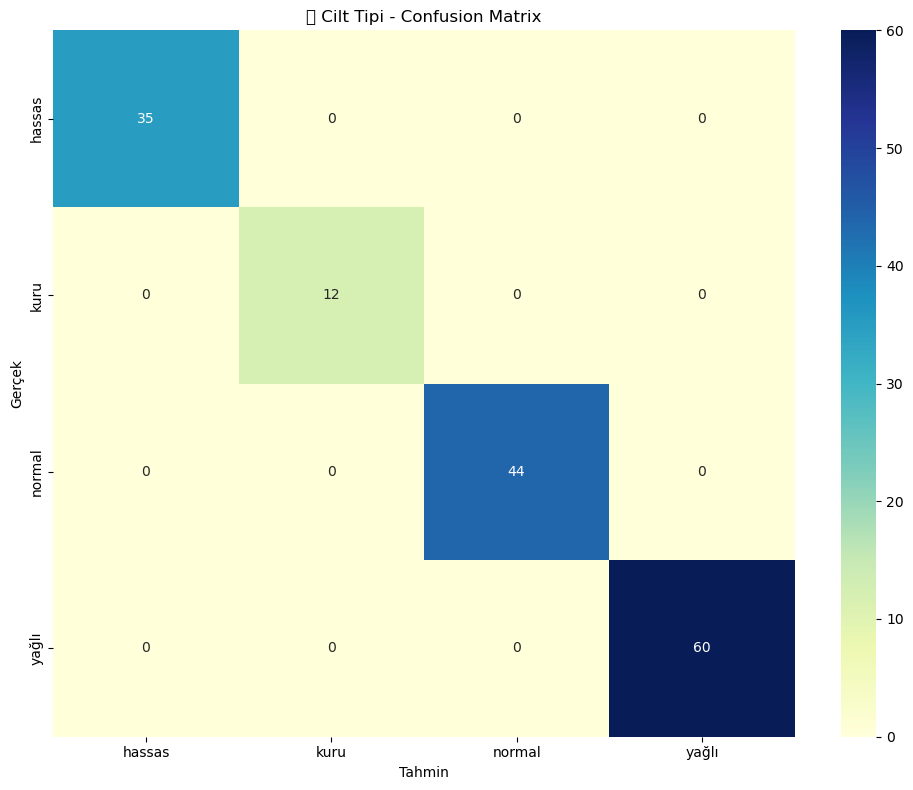

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Gerçek ve tahmin etiketleri
true_labels_cilt = test_dataset["labels"]

model_cilt.eval()
model_cilt.to("cpu")

pred_labels_cilt = []

for i in range(len(test_dataset)):
    input_ids = test_dataset[i]["input_ids"].unsqueeze(0).to("cpu")
    attention_mask = test_dataset[i]["attention_mask"].unsqueeze(0).to("cpu")
    with torch.no_grad():
        output = model_cilt(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(output.logits, dim=1).item()
    pred_labels_cilt.append(pred)

labels_cilt = le_cilt.classes_


print("🧠 Cilt Tipi - Classification Report:\n")
print(classification_report(true_labels_cilt, pred_labels_cilt, target_names=labels_cilt))

# Confusion matrix
cm_cilt = confusion_matrix(true_labels_cilt, pred_labels_cilt)

# Görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cilt, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels_cilt, yticklabels=labels_cilt)
plt.title("💧 Cilt Tipi - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.show()


/var/folders/fj/49__nmss1vq863jvp8hjmy7r0000gn/T/ipykernel_42169/342543575.py:27: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


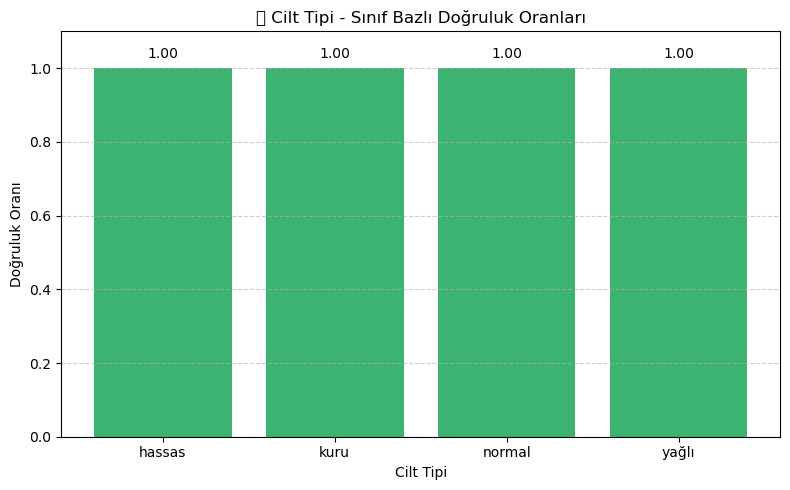

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(true_labels_cilt, pred_labels_cilt)


success_rates = cm.diagonal() / cm.sum(axis=1)

classes = le_cilt.classes_

# Grafik
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, success_rates, color='mediumseagreen')
plt.ylim(0, 1.1)
plt.title("💧 Cilt Tipi - Sınıf Bazlı Doğruluk Oranları")
plt.xlabel("Cilt Tipi")
plt.ylabel("Doğruluk Oranı")
plt.grid(axis='y', linestyle='--', alpha=0.6)


for bar, rate in zip(bars, success_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, rate + 0.02, f"{rate:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


/var/folders/fj/49__nmss1vq863jvp8hjmy7r0000gn/T/ipykernel_42169/706314311.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


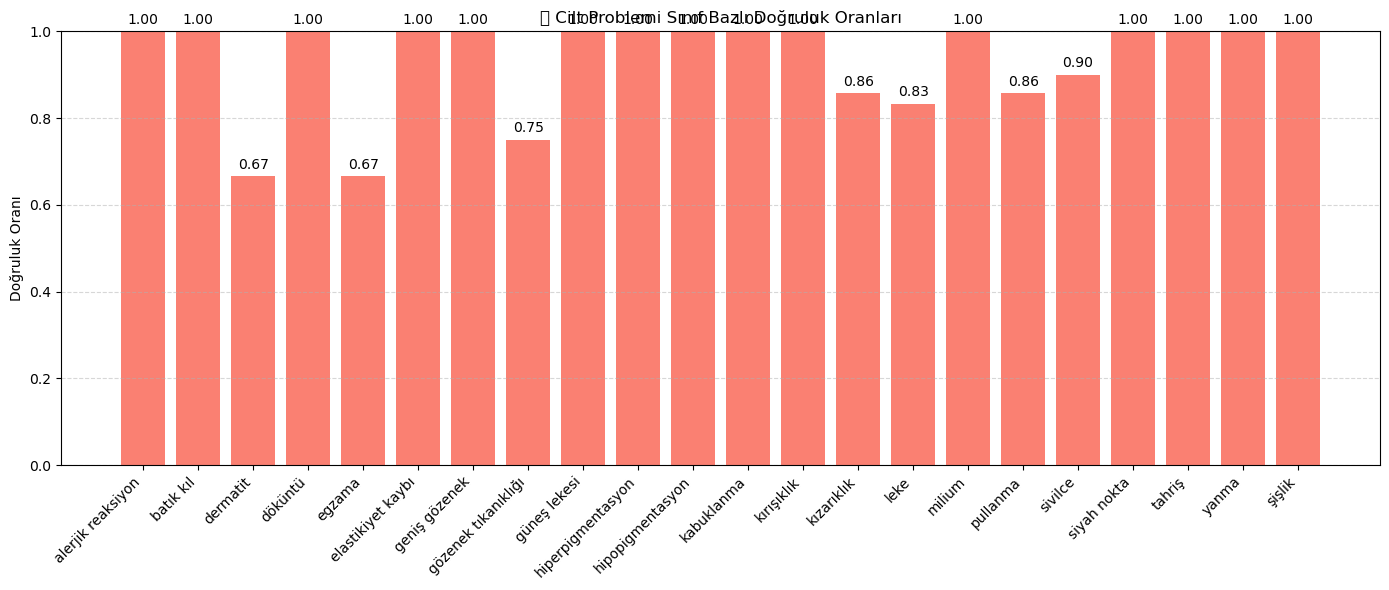

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm_prob = confusion_matrix(true_labels, pred_labels)  

success_rates_prob = cm_prob.diagonal() / cm_prob.sum(axis=1)

classes_prob = le_problemi.classes_

# Grafik
plt.figure(figsize=(14, 6))
bars = plt.bar(classes_prob, success_rates_prob, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Doğruluk Oranı")
plt.title("🔍 Cilt Problemi Sınıf Bazlı Doğruluk Oranları")
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar, acc in zip(bars, success_rates_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [17]:
predict_all("Cildim pul pul dökülüyor ve yüzümde kırmızı kabarcıklar var", df)

🧠 Tahminler:
💧 Cilt Tipi      : kuru (%96.62)
🔍 Cilt Problemi  : pullanma (%81.00)
🎁 Önerilen Ürün:
   💊 hyaluronik asit serum, yoğun nemlendirici krem, bariyer onarıcı krem, gliserin içerikli losyon, nem maskesi


In [18]:

import pickle

with open("le_cilt2.pkl", "wb") as f:
    pickle.dump(le_cilt, f)

In [19]:
import pickle

with open("le_problems.pkl", "wb") as f:
    pickle.dump(le_problemi, f)